In [1]:
import numpy as np
import scipy.linalg
import scipy.io
from scipy.interpolate import griddata
%matplotlib inline

In [48]:
mat = scipy.io.loadmat("assign2.mat")
mat.keys()

['a1',
 '__header__',
 '__globals__',
 'b4',
 'a3',
 'a2',
 'a4',
 'b2',
 'b3',
 '__version__',
 'b1']

In [53]:
dats = []
dats.append([mat["a1"], mat["b1"]])
dats.append([mat["a2"], mat["b2"]])
dats.append([mat["a3"], mat["b3"]])
dats.append([mat["a4"], mat["b4"]])

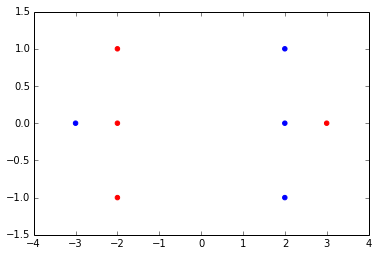

In [75]:
dat = [
    np.array([[-2, 0], [-2, 1], [-2,-1], [3, 0]]).T,
    np.array([[2, 0], [2, 1], [2,-1], [-3, 0]]).T
]

fig = plt.figure()
plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.show()

In [6]:
def med(c1, c2):
    """Create an med function"""
    z1 = np.mean(c1, axis=1)
    assert z1.shape == (2,)
    z2 = np.mean(c2, axis=1)
    assert z2.shape == (2,)

    def f(x):
        return -np.dot(z1,x) + 0.5*np.dot(z1.T,z1) < -np.dot(z2,x) + 0.5*np.dot(z2.T,z2)

    return f

In [8]:
from numpy.linalg import norm, inv

def ged(c1, c2):
    s1 = inv(np.cov(c1))
    assert s1.shape == (2,2)
    s2 = inv(np.cov(c2))
    assert s2.shape == (2,2)
    u1 = np.mean(c1, axis=1)
    assert u1.shape == (2,)
    u2 = np.mean(c2, axis=1)
    assert u2.shape == (2,)
    
    def f(x):
        return np.sqrt(np.dot(np.dot((x - u1),s1),(x - u1).T)) > \
               np.sqrt(np.dot(np.dot((x - u2),s2),(x - u2).T)) 
        
    return f

In [65]:
from itertools import chain

def knn(c1, c2, k, offset=5):
    # initiaslise with all the points from each class
    c1_len = c1.shape[1]
    zero_shape = (c1.shape[0], c1_len*2)
    c1_res = np.zeros(zero_shape)
    c1_count = 0
    c2_res = np.zeros(zero_shape)
    c2_count = 0
    c_train = np.concatenate((c1[:, :offset], c2[:, :offset]), axis=1)
    c_all = np.concatenate((c1, c2), axis=1)
    err_count = 0

    # iterate through all the test points using indexing
    # because numpy nditer is psychotic
    for c_ind in chain(xrange(offset), xrange(c1_len, c1_len+offset)):
        val = c_all[:, c_ind]
        # find the nearest K neighbours
        ind = np.argpartition(norm(c_train.T - val, axis=1), k+1)[:k+1][1:k+1]

        # class the point where the majority of the neighbours are
        sort_res = 0
        for ix in ind:
            if ix < c1.shape[1] - offset:
                sort_res += 1
            else:
                sort_res -= 1

        if sort_res > 0:
            c1_res[:, c1_count] = val
            c1_count += 1

            if c_ind > c1.shape[1]:
                err_count += 1
        else:
            c2_res[:, c2_count] = val
            c2_count += 1

            if c_ind <= c1.shape[1]:
                err_count += 1

    assert c1_count + c2_count == 2*offset
    return (c1_res[:, :c1_count], c2_res[:, :c2_count], err_count)

In [74]:
def get_err(funct, dat1, dat2, train=5):

    # get the function, calculate and return the error
    tot_res = 2.0*float(dat1.shape[1] - train)
    assert tot_res >= 2

    if type(funct) is tuple:
        res = funct[0](dat1, dat2, funct[1], train)
        return float(res[2]) / tot_res
    else:
        func = funct(dat1[:, :train], dat2[:, :train])
        tot_err = 0

        if funct == med:
            res = func(dat1[:, train:])
            tot_err += np.where(res == False)[0].shape[0]
            res = func(dat2[:, train:])
            tot_err += np.where(res == True)[0].shape[0]

        elif funct == ged:

            def ged_err(ged_func, ged_dat, expected):
                res = []
                for dat in list(ged_dat):
                    res.append(ged_func(dat))
                res = np.array(res, dtype=np.bool)
                return np.where(res == expected)[0].shape[0]

            tot_err += ged_err(func, dat1[:, train:].T, True)
            tot_err += ged_err(func, dat2[:, train:].T, False)

        assert tot_err <= tot_res
        return float(tot_err) / tot_res

In [66]:
funcs = [med, ged, (knn, 1), (knn, 3), (knn, 5)]
res = [[ [] for j in range(len(dats)) ] for i in range(len(funcs))]

for f_i, funct in enumerate(funcs):
    for d_i, dat in enumerate(dats):
        dat1 = dat[0]
        dat2 = dat[1]
        for x_i in list(np.linspace(5, 200, 40)):
            # get the training data from the classification data
            res[f_i][d_i].append(get_err(funct, dat1, dat2))
            dat1 = np.roll(dat1, 5, axis=1)
            dat2 = np.roll(dat2, 5, axis=1)

# get the means and variances for each classification method
final_mean = np.mean(res, axis=2)
final_var = np.std(res, axis=2)    

In [67]:
print(final_mean.T)
print(final_var.T)

[[ 0.076375   0.4411875  0.4725     0.4725     0.4725   ]
 [ 0.3305625  0.3169375  0.4725     0.4725     0.4725   ]
 [ 0.278625   0.3        0.4725     0.4725     0.4725   ]
 [ 0.2133125  0.3453125  0.4725     0.4725     0.4725   ]]
[[ 0.01468364  0.0730432   0.          0.          0.        ]
 [ 0.06131753  0.10349289  0.          0.          0.        ]
 [ 0.06246487  0.09726896  0.          0.          0.        ]
 [ 0.01814342  0.09318528  0.          0.          0.        ]]


In [72]:
res = [[ [] for j in range(len(dats)) ] for i in range(len(funcs))]

# jack-knife
for f_i, funct in enumerate(funcs):
    for d_i, dat in enumerate(dats):
        dat1 = dat[0]
        dat2 = dat[1]

        for offset in xrange(200):
            res[f_i][d_i].append(get_err(funct, dat1, dat2, offset=199))
            dat1 = np.roll(dat1, 1, axis=1)
            dat2 = np.roll(dat2, 1, axis=1)

p_err_final = np.sum(res, axis=2) / 200.0

In [73]:
print(p_err_final)

[[  1.50000000e-04   8.31250000e-04   6.62500000e-04   5.12500000e-04]
 [  2.33750000e-01   1.88881250e-01   1.55193750e-01   1.86625000e-01]
 [  1.24375000e-03   1.25625000e-03   1.18750000e-03   1.33125000e-03]
 [  1.26250000e-03   1.33750000e-03   1.21875000e-03   1.28750000e-03]
 [  1.24375000e-03   1.29375000e-03   1.19375000e-03   1.23750000e-03]]
